# 1. Data Import and preprocessing

### 1A. Import data

In [ ]:
import pandas as pd
import os

# Set directories
source_dir = ### ENTER PATHWAY TO THE DIREOCTORY CONTAINING THE EXCEL SHEET WITH LABELLED REPORTS ###

# Import Excel file
df = pd.read_excel(os.path.join(source_dir,'labelled_reports.xlsx'))

df.head(2) 
len(df)

### 1B. Shuffle data

In [ ]:
df = df.sample(frac=1)
df.head(2)

### 1C. Data preprocessing

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')
stop_words_english = stopwords.words('english')
stop_words_modified = [w for w in stop_words_english if w not in ['no', 'not']]
porter = PorterStemmer()

def preprocessor(text):
    
    #remove all text before 'CLINICAL DATA'
    text = re.sub(r'.*FINDINGS', '', text)
    
    # Remove newlines
    text = text.replace(r'\n', ' ')
    
    # Remove date
    date_pattern = r'[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,}'
    text = re.sub(date_pattern, ' ', text.lower())
    
    # Remove whitespace
    text = ' '.join(text.split())
    
    # Remove punctution, keep decimal points
    text = re.sub(r'[\W]+(?!\d)', ' ', text)
    
    # Remove the signature at the end of the report              
    
    if text.find(' i the teaching physician') != -1:
        body_pattern = re.compile(r'(.*) (?=i the teaching physician)')
        matched_text = body_pattern.search(text).group(1)
        
    elif text.find(' end of impression') != -1:
        body_pattern = re.compile(r'(.*) (?=end of impression)')
        matched_text = body_pattern.search(text).group(1)
    
    elif text.find(' radiologists signatures') != -1:
        body_pattern = re.compile(r'(.*) (?=radiologists signatures)')
        
        matched_text = body_pattern.search(text).group(1)
    
    else:
        matched_text = text
        
    return matched_text

def remove_words(clean_report): 
    clean_report_words = clean_report.split()
    stripped_report_words  = [word for word in clean_report_words if word.lower() not in stop_words_modified]
    stripped_report_text = ' '.join(stripped_report_words)
    return stripped_report_text


def porter_stemming(text):
    stemmed_report_words = [porter.stem(word) for word in text.split()]
    stemmed_report_text = ' '.join(stemmed_report_words)
    return stemmed_report_text

df['cleaned_report'] = df['Report'].apply(preprocessor)
df['stripped_report'] = df['cleaned_report'].apply(remove_words)
df['stemmed_report'] = df['stripped_report'].apply(porter_stemming)
df.head(2)

### 1D. Tokenizing

In [ ]:
def split_words(report): 
    report = report.split()
    return report

df['tokenized_report'] = df['stemmed_report'].apply(split_words)
df.head(2)

### 1E. Save Reports

In [ ]:
target_dir = ### ENTER PATHWAY TO THE DIREOCTORY FOR STORING THE EXCEL SHEET WITH PREPROCESSED REPORTS ###
df.to_excel(os.path.join(target_dir, 'preprocessed_reports.xlsx'))

# 2. Hyperparameter tuning

### 2A. Load Preprocessed Reports 

In [ ]:
import pandas as pd
import os

source_dir = ### ENTER PATHWAY TO THE DIREOCTORY CONTAINING THE EXCEL SHEET WITH PREPROCESSED REPORTS ###
df = pd.read_excel(os.path.join(source_dir, 'preprocessed_reports.xlsx')) 

print('Dimensions df are', df.shape)
df.head(2)

### 2B. Create hyperparameter grid

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid_dict = {'l2': [1, 2, 3, 5, 10],
                   'max_features':[100, 250, 500, 1000, 1500, 2000, 2500],
                   'ngram_range': [1, 2, 3, 4],
                   'outcome': ['Laterality_left', 'Laterality_right', 'Laterality_multifocal',
                               'Location_frontal', 'Location_temporal', 'Location_parietal',
                               'Location_occipital', 'Location_corpus_callosum', 
                               'Tumor_aspect_het_enhanc', 'Tumor_aspect_ring_enhanc',
                               'Tumor_aspect_necrosis', 'Tumor_aspect_cystic', 
                               'Characteristic_hemorrhage', 'Characteristic_edema', 'Characteristic_mass_effect'
                              ]
                  }

param_grid_list = list(ParameterGrid(param_grid_dict))
param_grid_list

parameter_grid = []
for dict in param_grid_list:
    hyperparameters = list(dict.values())
    parameter_grid.append(hyperparameters)

#NOTE: parameter grid is sorted in alphabetical order
print('Size parametergrid is', len(parameter_grid))
parameter_grid

### 2C. Cross-validation hyperparameter tuning

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model
import scipy.sparse as sp
import pandas as pd
import numpy as np
import os

outcome_column = []
l2_column = []
max_features_column = []
ngram_range_column = []
auc_column = []
auc_std_column = []
ca_column = []
ca_std_column = []

target_dir = ### ENTER PATHWAY TO THE DIREOCTORY FOR STORING THE RESULTS OF THE HYPERPARAMETER TUNING ###

start_gridsearch = 1

for  l2, max_features, ngram_range, outcome in parameter_grid:
    
    print('### Grid Search', start_gridsearch,'for', outcome)
    
    word_vectorizer = TfidfVectorizer(ngram_range=(1,ngram_range),max_features=max_features)
    word_vectorizer.fit(df['tokenized_report'])
    
    X = word_vectorizer.transform(df['tokenized_report']).toarray()
    y = np.asarray(df[outcome])
    
    kfold = KFold(n_splits=10, random_state=1)
    
    auc_folds = []
    ca_folds = []
    
    for train_index, val_index, in kfold.split(X, y):
        model_lasso = LogisticRegression(penalty = 'l1', C=l2, max_iter=200)
        model_lasso.fit(X[train_index], y[train_index])
 
        auc = roc_auc_score(y[val_index], model_lasso.predict_proba(X[val_index])[:,1])
        ca = accuracy_score(y[val_index],  model_lasso.predict(X[val_index]))

        auc_folds.append(auc)
        ca_folds.append(ca)
    
    auc_mean = np.mean(auc_folds)
    auc_std = np.std(auc_folds)
    ca_mean = np.mean(ca_folds)
    ca_std = np.std(ca_folds)
    
    print('The mean CV AUC for grid search', start_gridsearch ,
            round(auc_mean,2),'±', round(auc_std,3))
    print('The mean CV CA for grid search', start_gridsearch ,
          round(ca_mean,2)*100, '±', round(ca_std,3)*100)
    
    outcome_column.append(outcome)
    l2_column.append(l2)
    max_features_column.append(max_features)
    ngram_range_column.append(ngram_range)
    auc_column.append(auc_mean)
    auc_std_column.append(auc_std)
    ca_column.append(ca_mean)
    ca_std_column.append(ca_std)
    
    start_gridsearch = start_gridsearch + 1
    
df_performance = pd.DataFrame(list(zip(outcome_column, l2_column, max_features_column, ngram_range_column,
                                    auc_column, auc_std_column, ca_column, ca_std_column)))

df_performance.columns = ['Outcome', 'l2', 'max_features', 'ngram_range', 'auc', 'auc_std',
                          'ca', 'ca_std']

df_performance.to_excel(os.path.join(target_dir, 'hyperparameter_tuning.xlsx'))
df_performance

 # 3. Compute final results with optimal hyperparametergrid

### 3A. Extract optimal hyperparameter settings

In [ ]:
import pandas as pd
import os
import numpy as np

target_dir =  ### ENTER PATHWAY TO THE DIREOCTORY CONTAINING THE RESULTS OF THE HYPERPARAMETER TUNING ###
df_performance = pd.read_excel(os.path.join(target_dir, 'hyperparameter_tuning.xlsx'))

df_performance['auc_ca'] = df_performance['auc'] + df_performance['ca']

df_optimal_parameters = df_performance.loc[df_performance.reset_index().groupby(['Outcome'])['auc_ca'].idxmax()]

df_optimal_parameters = df_optimal_parameters.sort_values(by=['auc'], ascending=False)

conditions = [
    df_optimal_parameters['Outcome'].str.contains("Laterality"),
    df_optimal_parameters['Outcome'].str.contains("Location"),
    df_optimal_parameters['Outcome'].str.contains("Tumor_aspect"),
    df_optimal_parameters['Outcome'].str.contains("Characteristic")]

choices = ['laterality characteristics', 'locational characteristics', 'tumor aspect', 'other characteristics']

df_optimal_parameters['Domain'] = np.select(conditions, choices)

conditions = [
    df_optimal_parameters['Outcome'].str.contains("left"),
    df_optimal_parameters['Outcome'].str.contains("right"),
    df_optimal_parameters['Outcome'].str.contains("multifocal"),
    df_optimal_parameters['Outcome'].str.contains("frontal"),
    df_optimal_parameters['Outcome'].str.contains("temporal"),
    df_optimal_parameters['Outcome'].str.contains("parietal"),
    df_optimal_parameters['Outcome'].str.contains("occipital"),
    df_optimal_parameters['Outcome'].str.contains("corpus_callosum"),
    df_optimal_parameters['Outcome'].str.contains("het_enhanc"),
    df_optimal_parameters['Outcome'].str.contains("ring_enhanc"),
    df_optimal_parameters['Outcome'].str.contains("necrosis"),
    df_optimal_parameters['Outcome'].str.contains("cystic"),
    df_optimal_parameters['Outcome'].str.contains("hemorrhage"),
    df_optimal_parameters['Outcome'].str.contains("edema"),
    df_optimal_parameters['Outcome'].str.contains("mass_effect"),
]

choices = ['Left', 'Right', 'Multifocality', 'Frontal lobe', 'Temporal lobe',
          'Parietal lobe', 'Occipital lobe', 'Corpus callosum', 'Heterogenous enhancement',
          'Ring enhancement', 'Necrosis', 'Cystic', 'Hemorrhage', 'Edema', 'Mass effect']

df_optimal_parameters['Subdomain'] = np.select(conditions, choices)

df_optimal_parameters = df_optimal_parameters[['Outcome', 'Domain', 'Subdomain', 'l2', 'max_features', 'ngram_range']]

#Metric grid
optimal_paramater_grid_metrics = df_optimal_parameters.values.tolist()

optimal_paramater_grid_metrics

### 3B. Create final results with optimal hyperparametergrid

In [7]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn import linear_model
import pandas as pd
import scipy.sparse as sp
import numpy as np
import os

outcome_column = []
domain_column = []
subdomain_column = []
l2_column = []
max_features_column = []
ngram_range_column = []
auc_column = []
auc_std_column = []
ca_column = []
ca_std_column = []

start_gridsearch = 1

for outcome, domain, subdomain, l2, max_features, ngram_range in optimal_paramater_grid_metrics:
    
    #Apply same preprocessing steps per grid search
    #print('### Grid Search', start_gridsearch,'for', outcome)
    
    word_vectorizer = TfidfVectorizer(ngram_range=(1,ngram_range),max_features=max_features)
    word_vectorizer.fit(df['tokenized_report'])
    
    X = word_vectorizer.transform(df['tokenized_report']).toarray()
    y = np.asarray(df[outcome])
    
    kfold = KFold(n_splits=10, random_state=1)
    
    auc_folds = []
    ca_folds = []
    
    #Create metrics per fold
    for train_index, val_index, in kfold.split(X, y):
        model_lasso = LogisticRegression(penalty = 'l1', C=l2, max_iter=200)
        model_lasso.fit(X[train_index], y[train_index])
    
        auc = roc_auc_score(y[val_index], model_lasso.predict_proba(X[val_index])[:,1])
        auc_folds.append(auc)
        
        ca = accuracy_score(y[val_index],  model_lasso.predict(X[val_index]))
        ca_folds.append(ca)

    #Calculate mean performance and standard deviation across folds
    auc_mean = np.mean(auc_folds)
    auc_std = np.std(auc_folds)    
    
    ca_mean = np.mean(ca_folds)
    ca_std = np.std(ca_folds)
    
    #Append mean and standard deviation metrics per grid search
    outcome_column.append(outcome)
    domain_column.append(domain)
    subdomain_column.append(subdomain)
    l2_column.append(l2)
    max_features_column.append(max_features)
    ngram_range_column.append(ngram_range)
    auc_column.append(auc_mean)
    auc_std_column.append(auc_std)
    ca_column.append(ca_mean)
    ca_std_column.append(ca_std)
    
    start_gridsearch = start_gridsearch + 1
    
df_performance = pd.DataFrame(list(zip(outcome_column, domain_column, subdomain_column, 
                                    l2_column, max_features_column, ngram_range_column,
                                    auc_column, auc_std_column, ca_column, ca_std_column)))

df_performance.columns = ['Outcome', 'Domain', 'Subdomain', 'l2', 'max_features', 'ngram_range', 'auc', 'auc_std',
                          'ca', 'ca_std']

df_performance['ca'] = df_performance['ca'] * 100
df_performance['ca_std'] = df_performance['ca_std'] * 100

cols1 = ['ca', 'ca_std']
cols3 = ['auc', 'auc_std', 'ca', 'ca_std']

df_performance[cols1] = df_performance[cols1].round(1)
df_performance[cols3] = df_performance[cols3].round(3)

df_performance['AUC'] = df_performance['auc'].apply(str) + '±' + df_performance['auc_std'].apply(str)
df_performance['Accuracy'] = df_performance['ca'].apply(str) + '±' + df_performance['ca_std'].apply(str)

df_performance = df_performance[['Outcome', 'Domain', 'Subdomain', 'l2', 'max_features', 'ngram_range', 
                                 'auc', 'auc_std', 'ca', 'ca_std', 'AUC', 'Accuracy']]

df_performance['Subdomain'] = pd.Categorical(df_performance['Subdomain'], ["Left", "Right", "Multifocality",
                                                              "Frontal lobe", "Temporal lobe", "Parietal lobe", "Occipital lobe", "Corpus callosum",
                                                              "Necrosis", "Cystic", "Ring enhancement", "Heterogenous enhancement",
                                                              "Hemorrhage", "Edema", "Mass effect"])

df_performance = df_performance.sort_values('Subdomain')
df_performance 

target_dir = ### ENTER PATHWAY TO THE DIREOCTORY FOR STORING THE FINAL RESULTS ###

df_performance.to_excel(os.path.join(target_dir, 'final_results.xlsx'))
df_performance

,Outcome,Domain,Subdomain,l2,max_features,ngram_range,auc,auc_std,ca,ca_std,AUC,Accuracy
0,Laterality_left,laterality characteristics,Left,2,250,3,0.984,0.017,93.6,3.4,0.984±0.017,93.6±3.4
2,Laterality_right,laterality characteristics,Right,1,2500,1,0.973,0.024,94.1,3.2,0.973±0.024,94.1±3.2
14,Laterality_multifocal,laterality characteristics,Multifocality,5,2500,3,0.816,0.048,78.6,4.4,0.816±0.048,78.6±4.4
6,Location_frontal,locational characteristics,Frontal lobe,2,2000,1,0.960,0.015,89.1,3.5,0.96±0.015,89.1±3.5
4,Location_temporal,locational characteristics,Temporal lobe,10,2500,2,0.965,0.022,91.1,3.0,0.965±0.022,91.1±3.0
3,Location_parietal,locational characteristics,Parietal lobe,5,2000,2,0.966,0.022,91.3,3.3,0.966±0.022,91.3±3.3
1,Location_occipital,locational characteristics,Occipital lobe,2,250,2,0.982,0.019,96.6,2.2,0.982±0.019,96.6±2.2
9,Location_corpus_callosum,locational characteristics,Corpus callosum,5,500,3,0.945,0.031,93.1,3.3,0.945±0.031,93.1±3.3
5,Tumor_aspect_necrosis,tumor aspect,Necrosis,3,250,1,0.962,0.023,92.2,2.0,0.962±0.023,92.2±2.0
7,Tumor_aspect_cystic,tumor aspect,Cystic,2,500,1,0.957,0.056,94.0,2.1,0.957±0.056,94.0±2.1


### 3C. Construct parameter grid for figures

In [ ]:
df_performance_figures = df_performance.drop(['ca', 'ca_std', 'AUC', 'Accuracy'], axis=1)

optimal_parameter_grid_figures = [
    df_performance_figures.loc[df_performance_figures['Domain'] == 'laterality characteristics'].values.tolist(),
    df_performance_figures.loc[df_performance_figures['Domain'] == 'locational characteristics'].values.tolist(),
    df_performance_figures.loc[df_performance_figures['Domain'] == 'tumor aspect'].values.tolist(),
    df_performance_figures.loc[df_performance_figures['Domain'] == 'other characteristics'].values.tolist()]

vector_nature_color_codes = ['#E64B35FF', '#4DBBD5FF', '#00A087FF', '#3C5488FF', '#F39B7FFF']

optimal_parameter_grid_figures

for domain in optimal_parameter_grid_figures:
    i = 0
    for subdomain in domain:
        subdomain.append(vector_nature_color_codes[i])
        i = i + 1

#Figure grid
optimal_parameter_grid_figures

### 3D. Compute ROC Plots

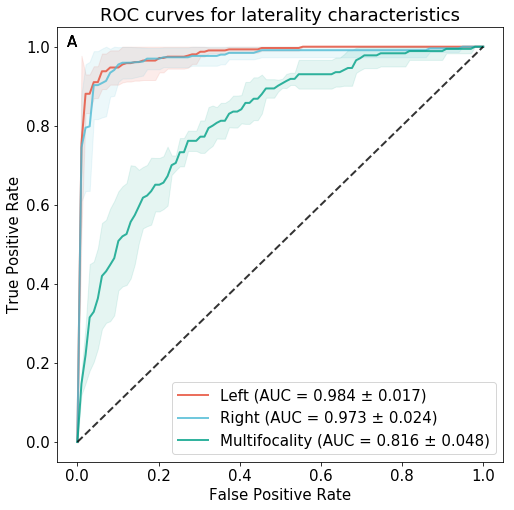

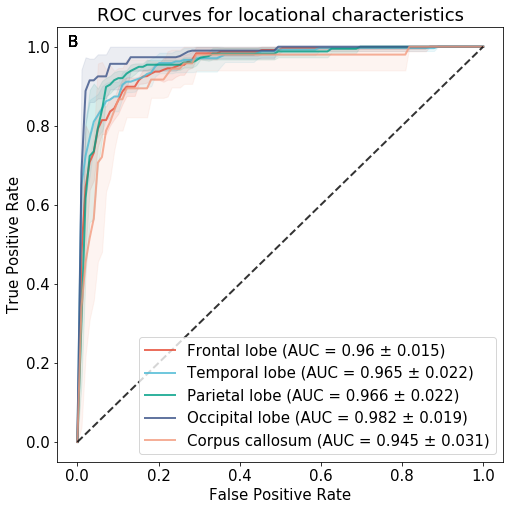

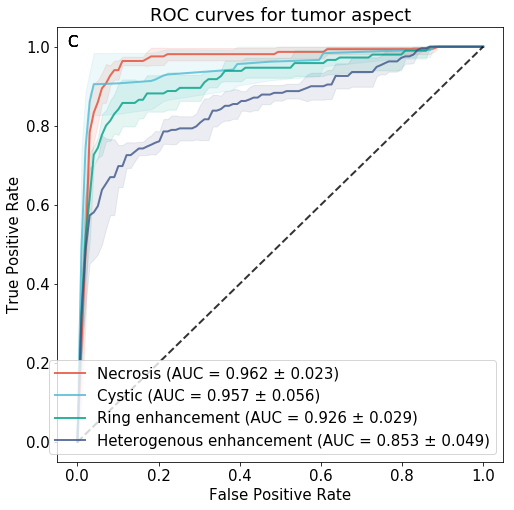

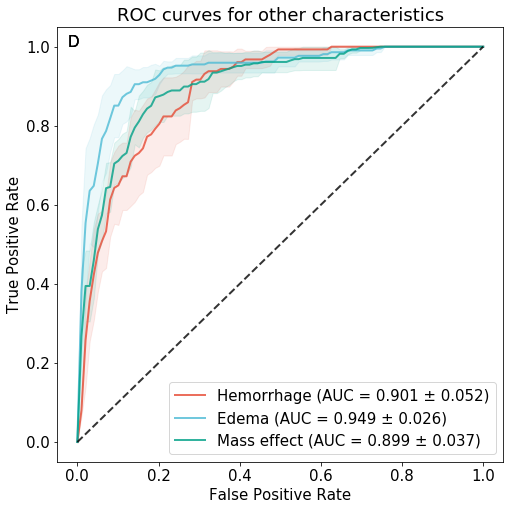

In [6]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy.sparse as sp
from scipy import interp
import pandas as pd
import numpy as np
import matplotlib
import os

matplotlib.rcParams.update({'font.size': 15})

i = 1
for Domain in optimal_parameter_grid_figures:
    
    plt.figure(figsize=(8, 8)).clf()
    
    for  outcome, domain, subdomain, l2, max_features, ngram_range, auc_score, auc_score_std, color_code in Domain:

        #print('### Grid Search', start_gridsearch,'for', outcome)

        word_vectorizer = TfidfVectorizer(ngram_range=(1,ngram_range),max_features=max_features)
        word_vectorizer.fit(df['tokenized_report'])

        X = word_vectorizer.transform(df['tokenized_report']).toarray()
        y = np.asarray(df[outcome])

        kfold = KFold(n_splits=5, random_state=1, shuffle = False)

        tprs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train_index, val_index, in kfold.split(X, y):
            model_lasso = LogisticRegression(penalty = 'l1', C=l2, max_iter=200)
            model_lasso.fit(X[train_index], y[train_index])

            fpr, tpr, thresholds = metrics.roc_curve(y[val_index], model_lasso.predict_proba(X[val_index])[:,1])
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        plt.plot(mean_fpr, mean_tpr, color=color_code,
             label="{} (AUC = {} ± {})".format(subdomain, round(auc_score,3), round(auc_score_std,3)),
             lw=2, alpha=.8)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color_code, alpha=.1)
                     #label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves for {}'.format(domain))
        plt.legend(loc="lower right")
        
        if domain == 'laterality characteristics':
            panel = 'A'
        elif domain == 'locational characteristics':
            panel = 'B'
        elif domain == 'tumor aspect':
            panel = 'C'
        else:
            panel = 'D'
        
        plt.text(-0.025, 1, s = panel)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
             label='Chance', alpha=.8)
    
    path_figure_output = ### ENTER PATHWAY TO THE DIREOCTORY FOR STORING THE FIGURES ###
    plt.savefig(os.path.join(path_figure_output,'ROC curves {}.pdf'.format(domain)))
    plt.savefig('ROC_curve.eps', format = 'eps', dpi = 1000)
    
    plt.show()
    